## https://www.kaggle.com/c/house-prices-advanced-regression-techniques

# Links to each features

Go to <a href=#baseline_model>baseline_model</a>

Go to <a href=#first_modeling>first_modeling</a>

Go to [label_encoding](#label_encoding)

Go to [combine_two](#combine_two)

Go to [get square and cubic](#sqcb)

Go to [normalize](#normalize)

Go to [modeling](#modeling)

In [162]:
import pandas as pd
import numpy as np

# for plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff

# for modeling
import lightgbm as lgb
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, mean_squared_error, mean_squared_log_error
from sklearn.impute import SimpleImputer
from operator import itemgetter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from scipy.stats import chi2_contingency
from tqdm import tqdm
import itertools
import warnings
warnings.filterwarnings(action='once')

In [164]:
tqdm.pandas()

/Users/junseoklee/kaggle/IEEE-venv/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [163]:
tqdm._instances.clear()

In [88]:
df = pd.read_csv('train.csv') #,dtype=df_dtypes  #df_dtypes at the bottom

In [89]:
test = pd.read_csv('test.csv') #df_dtypes at the bottom

# Data preprocessing

## To get a baseline model, let's do basic data preprocessing

- #### Drop the features whose missing data are more than 50% 
- #### One-hot-encoding for object features
- #### Fill missing values with the mean of each feature

In [5]:
def threshold_null_cols(df,threshold = 0.5):
    null_cols = df.isnull().sum(axis=0)/len(df) > threshold
    return list(null_cols[null_cols].keys())

def drop_cols(df,col_name_list):
    df1 = df.drop(col_name_list,axis='columns')
    return df1

def one_hot(df, dummy_na = False):
    df1 = pd.get_dummies(df, dummy_na=dummy_na)
    return df1

def fill_na(df1,mean_mode = 'mean'):
    if mean_mode == 'mode':
        df1.fillna(df1.mode(),inplace = True)
    df1.fillna(df1.mean(),inplace = True)

In [6]:
df1 = one_hot( drop_cols(df, threshold_null_cols(df)  )  )

In [7]:
fill_na(df1)

In [8]:
df1.shape

(1460, 277)

In [9]:
test1 = one_hot( drop_cols(test, threshold_null_cols(test)  )  )

In [10]:
fill_na(test1)

In [11]:
test1.shape

(1459, 255)

<a id="baseline_model"/>

# Baseline Model

## Let's get a baseline model with df1

- ### I'll train with Random Forest Classifier and get a score using validation set (train:val = 0.8:0.2)

In [12]:
def make_train_val(df, val_size = 0.2):
    # Split the data into training and testing sets
    train, val = train_test_split(df, test_size = val_size)
    assert train.shape[0]+val.shape[0] == df.shape[0], 'data wrong'
    assert train.shape[1] == val.shape[1], 'data wrong'
    return train, val

def make_XY(df, target, drop_cols = []):
    dataX, dataY = df.drop([target]+drop_cols, axis=1), df[target]
    return dataX, dataY

In [13]:
target = 'SalePrice'
cols = [col for col in df1.columns if (col in test1.columns) and (col != 'Id')]
train, val = make_train_val(pd.concat([df1[cols],df[target]],axis=1))
trainX, trainY = make_XY(train,target)
valX, valY = make_XY(val,target)
del train, val

In [14]:
# Make the random forest classifier
random_forest = RandomForestRegressor(n_estimators = 100,  max_depth=10, n_jobs=-1)
# Train with the training data
random_forest.fit(trainX, trainY)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [15]:
# Function showing scores of the model on a validation set
def output(model, data_X, data_Y, return_rmsle=False):
    ## Results on val data:
    pred = model.predict(data_X)

    rmsle = np.sqrt(mean_squared_log_error(data_Y, pred))
    print("root mean squared log error:", rmsle,"\n")
#     print("root mean_squared error:", mse**(1/2),"\n")
        
    if return_rmsle:
        return rmsle

In [16]:
output(random_forest, valX, valY)

root mean squared log error: 0.1443893894323584 



## Sample Submission

In [76]:
test_predic = random_forest.predict(test1[cols])

In [77]:
submission = pd.DataFrame({'Id': test['Id'].values, 'SalePrice': test_predic})

In [78]:
submission.to_csv('submission.csv',index=False)

- ### Our baseline rmsle is 0.14259513368111795. Let's improve this with further feature engineering.

<a id="first_modeling" />

# First Modeling to get important features

In [17]:
df1 = df1[cols+[target]]
test1 = test1[cols]

In [21]:
num_cols = [col for col in df.columns if (df[col].dtypes.kind in 'buicf') and (col not in ['Id','SalePrice'])]
obj_cols = [col for col in df.columns if df[col].dtypes.kind in 'OS']

In [22]:
rs = ShuffleSplit(n_splits=1, test_size=.25)

In [23]:
def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False

In [28]:
lgb_reg = lgb.LGBMRegressor(num_leaves = 300, n_estimators=10000,
                        n_jobs=-1,
                        max_depth=10,
                        learning_rate=0.02,
                        subsample=0.5,
                        colsample_bytree=0.5,
                        min_data_in_leaf = 5,
                        min_split_gain = 0,
#                         min_child_weight = 0.03454472573214212,
#                         reg_alpha= 0.3299927210061127,
#                         reg_lambda= 0.3885237330340494,
                        min_child_weight = 0.03454472573214212,
                        reg_alpha= 0.3,
                        reg_lambda= 0.3,  
                        subsample_for_bin = 200000)

In [29]:
df1X = df1.drop(target, axis=1)
feature_names = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df1.columns]
for train_idx, val_idx in rs.split(df1, df[target]):
    trainX, trainY = df1X.iloc[train_idx], df[target].iloc[train_idx]
    valX, valY = df1X.iloc[val_idx], df[target].iloc[val_idx]

In [30]:
features = list(df1X.columns)
lgb_reg.fit(trainX[features], trainY,\
           eval_metric = rmsle,\
            eval_set = [(trainX[features], trainY),(valX[features],valY)]\
            ,eval_names = ['train','val'], verbose=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	train's l2: 2.85285e+08	train's RMSLE: 0.0978882	val's l2: 8.76138e+08	val's RMSLE: 0.158049
[200]	train's l2: 4.54747e+07	train's RMSLE: 0.0386346	val's l2: 5.98053e+08	val's RMSLE: 0.130468
[300]	train's l2: 1.90475e+07	train's RMSLE: 0.0272899	val's l2: 5.7069e+08	val's RMSLE: 0.127075
[400]	train's l2: 1.11181e+07	train's RMSLE: 0.0221117	val's l2: 5.64053e+08	val's RMSLE: 0.126098
[500]	train's l2: 6.96012e+06	train's RMSLE: 0.0187104	val's l2: 5.59698e+08	val's RMSLE: 0.125661
[600]	train's l2: 4.82097e+06	train's RMSLE: 0.016128	val's l2: 5.59388e+08	val's RMSLE: 0.125427
Early stopping, best iteration is:
[584]	train's l2: 5.08494e+06	train's RMSLE: 0.0165158	val's l2: 5.59222e+08	val's RMSLE: 0.125463


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
              importance_type='split', learning_rate=0.02, max_depth=10,
              min_child_samples=20, min_child_weight=0.03454472573214212,
              min_data_in_leaf=5, min_split_gain=0, n_estimators=10000,
              n_jobs=-1, num_leaves=300, objective=None, random_state=None,
              reg_alpha=0.3, reg_lambda=0.3, silent=True, subsample=0.5,
              subsample_for_bin=200000, subsample_freq=0)

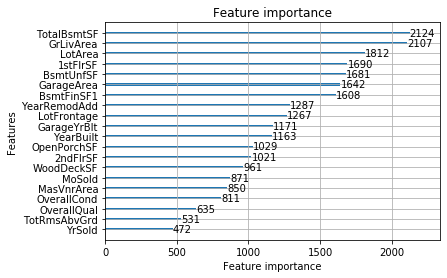

In [32]:
lgb.plot_importance(lgb_reg,max_num_features=20 , importance_type = 'split')

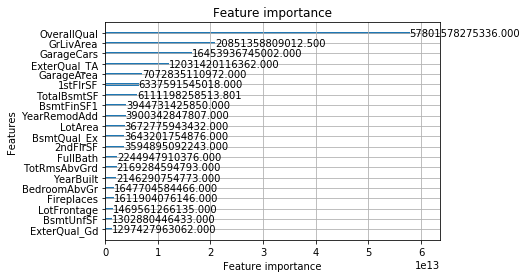

In [33]:
lgb.plot_importance(lgb_reg,max_num_features=20 , importance_type = 'gain')

In [34]:
def feature_in_use(feature_to_look, features_to_use, verbose = False):
#    feature_to_look = 'email'
    if type(features_to_use) == pd.DataFrame:
        features_to_use = features_to_use.columns
    feature_in_use_list = []
    for feature in features_to_use:
        if feature_to_look in feature:
                if verbose:
                    print(feature)
                feature_in_use_list.append(feature)
    return feature_in_use_list

In [178]:
def large_cor_cols(df1,target,threshold,num_itr_to_avg,  verbose = False):
    cor = {}
    dfX = df1.drop(target,axis=1)
    for i in range(num_itr_to_avg):
        cor[i] = abs(dfX.apply(lambda x: x.corr(df1[target])))
        if i == 0:
            cor_df = cor[i]
        else:
            cor_df = pd.concat([cor_df, cor[i]], axis = 1, sort = False) 
        
    cor_sort = cor_df.mean(axis=1).sort_values(ascending=False)

    lg_cor = cor_sort[cor_sort >= threshold]
    if verbose:
        print(lg_cor.to_string())
        print(f'------ threshold = {threshold} ------')
        print(cor_sort[cor_sort < threshold].to_string())
    lg_cor_cols =  list(lg_cor.index.values)

    return lg_cor_cols

In [52]:
lg_cor_cols = large_cor_cols(df1,target = target, threshold=0.01,num_itr_to_avg=20,verbose = True)

SalePrice                1.000000
OverallQual              0.790982
GrLivArea                0.708624
GarageCars               0.640409
GarageArea               0.623431
TotalBsmtSF              0.613581
1stFlrSF                 0.605852
ExterQual_TA             0.589044
FullBath                 0.560664
BsmtQual_Ex              0.553105
TotRmsAbvGrd             0.533723
YearBuilt                0.522897
KitchenQual_TA           0.519298
YearRemodAdd             0.507101
KitchenQual_Ex           0.504094
Foundation_PConc         0.497734
MasVnrArea               0.475241
GarageYrBlt              0.470177
Fireplaces               0.466929
ExterQual_Gd             0.452466
BsmtQual_TA              0.452394
ExterQual_Ex             0.451164
BsmtFinType1_GLQ         0.434597
HeatingQC_Ex             0.434543
GarageFinish_Fin         0.419678
GarageFinish_Unf         0.410608
Neighborhood_NridgHt     0.402149
BsmtFinSF1               0.386420
MasVnrType_None          0.374468
SaleType_New  

<a id="label_encoding"/>

# Label Encoding by an order of mean SalePrice

In [166]:
def labelen_by_order(df,cols = [], target = target, df_test = pd.DataFrame()):
    if cols == []:
        cols = df.columns
    df1 = df.copy()
    if not df_test.empty:
        test1 = df_test.copy()
    for col in tqdm(cols):
        if df1[col].dtype.kind not in 'OS':
            continue
        label = {}
        for i,idx in enumerate(df1.groupby(col)[target].agg("mean").sort_values().index):
            label[idx]=i
        label_mean = np.array(list(label.values())).mean()
        if not df_test.empty:
            for idx in set(test1[col].unique())-set(df1[col].unique()):
                label[idx]=label_mean
            test1[col] = test1[col].map(label)
        df1[col] = df1[col].map(label)
    if df_test.empty:
        return df1
    else:
        return df1, test1

In [124]:
df1, test1 = labelen_by_order(df,df_test = test)

In [129]:
lg_cor_cols = large_cor_cols(df1,target = target, threshold=0.05,num_itr_to_avg=20,verbose = True)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
Neighborhood     0.696882
ExterQual        0.682639
KitchenQual      0.659600
BsmtQual         0.644019
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
PoolQC           0.595229
FullBath         0.560664
Alley            0.534319
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
GarageFinish     0.513105
YearRemodAdd     0.507101
Foundation       0.505503
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
GarageType       0.445598
MasVnrType       0.429020
HeatingQC        0.427649
BsmtFinSF1       0.386420
Exterior1st      0.371400
SaleType         0.366821
Exterior2nd      0.365384
BsmtFinType1     0.353750
BsmtExposure     0.352958
LotFrontage      0.351799
MSZoning         0.324610
WoodDeckSF       0.324413
MiscFeature      0.322456
2ndFlrSF         0.319334
OpenPorchSF      0.315856
FireplaceQu      0.295794
HalfBath    

In [131]:
lg_cor_cols = [col for col in lg_cor_cols if col not in ["Id",target]]

In [132]:
df1 = df1[[target]+lg_cor_cols]
test1 = test1[lg_cor_cols]

In [172]:
df11.shape

(1460, 2486)

<a id="combine_two"/>

# combine two features

In [165]:
from itertools import combinations
for col1, col2 in tqdm(combinations(lg_cor_cols,2)):
    new = col1+"__"+col2
    df1[new] = df[col1].astype(str)+"__"+df[col2].astype(str)
    test1[new] = test[col1].astype(str)+"__"+test[col2].astype(str)
df11, test11 = labelen_by_order(df1,cols = feature_in_use("__",df1),df_test = test1)

1335it [05:00,  4.45it/s]]
2415it [00:14, 166.04it/s]


In [385]:
lg_cor_cols11 = large_cor_cols(df11,target = target, threshold=0.3,num_itr_to_avg=20)

In [405]:
from collections import defaultdict
used = defaultdict(int)
feature = []
for col in feature_in_use("__",lg_cor_cols11):
    c1, c2 = col.split("__")
    used[c1]+=1
    used[c2]+=1
    if (used[c1] * used[c2])<=4:
        feature.append(col)

In [406]:
len(feature)

11

In [407]:
feature

['Neighborhood__TotalBsmtSF',
 'GrLivArea__TotalBsmtSF',
 'TotalBsmtSF__OpenPorchSF',
 'GrLivArea__Neighborhood',
 'OverallQual__GrLivArea',
 'Neighborhood__1stFlrSF',
 '1stFlrSF__YearBuilt',
 'TotalBsmtSF__2ndFlrSF',
 'OverallQual__LotArea',
 'OpenPorchSF__LotArea',
 'Neighborhood__GarageArea']

In [389]:
features = lg_cor_cols+feature

In [378]:
features = large_cor_cols(df11[features+[target]],target = target, threshold=0.3,num_itr_to_avg=20)

In [390]:
len(features)

74

In [391]:
features = [col for col in features if (col in df11.columns) and (col in test11.columns)]

In [392]:
df1 = df11[features+[target]]
test1 = test11[features]

<a id="sqcb"/>

# get squre and cubic of numerical features

In [219]:
df12 = pd.DataFrame()
test12 = pd.DataFrame()
for col in num_cols:
    df12[col+"__sq"]=df[col]**2
    df12[col+"__cb"]=df[col]**3
    test12[col+"__sq"]=test[col]**2
    test12[col+"__cb"]=test[col]**3

In [220]:
df12[target] = df[target]

In [221]:
sqcb_features = large_cor_cols(df12,target = target, threshold=0.3,num_itr_to_avg=20)

In [393]:
for col in sqcb_features:
    df1[col] = df12[col]
    test1[col] = test12[col]

In [357]:
bad_cols = {}
n = len(test)
for col in obj_cols:
    test_uniq = test[col].isin(set(test[col].unique())-set(df[col].unique())).sum()
    if test_uniq/n >0.001:
        bad_cols[col]=test_uniq/n

In [358]:
bad_cols

{'MSZoning': 0.0027416038382453737,
 'Utilities': 0.0013708019191226869,
 'Functional': 0.0013708019191226869}

In [394]:
df1.fillna(df1.mean(),inplace=True)

In [395]:
test1.fillna(test1.mean(),inplace=True)

In [397]:
df1.shape

(1460, 100)

In [398]:
test1.shape

(1459, 99)

<a id="normalize"/>

# Normalize

In [430]:
from sklearn.preprocessing import StandardScaler
def normalize_df(df, target, df_test):
    dataX, dataY = df.drop(target, axis=1), df[target]
    scaler = StandardScaler()
    scaler.fit(dataX)
    dataX = scaler.transform(dataX)
    testX = scaler.transform(df_test)
    return dataX, dataY, testX

In [494]:
df1X, df1Y, test1X = normalize_df(df1, target, test1)

<a id="modeling"/>

# Modeling

In [507]:
lgb_reg = lgb.LGBMRegressor(num_leaves = 500, n_estimators=10000,
                        n_jobs=-1,
                        max_depth=5,
                        learning_rate=0.01,
                        subsample=0.5,
                        colsample_bytree=0.5,
                        min_data_in_leaf = 10,
#                         min_child_weight = 0.03454472573214212,
#                         reg_alpha= 0.3299927210061127,
#                         reg_lambda= 0.3885237330340494,
                        min_child_weight = 0.03454472573214212,
                        reg_alpha= 0.3,
                        reg_lambda= 0.3,  
                        subsample_for_bin = 200000,
                        min_split_gain = 0)

In [508]:
rs = ShuffleSplit(n_splits=1, test_size=.2)
for train_idx, val_idx in rs.split(df1X, df[target]):
    trainX, trainY = df1X[train_idx], df[target].iloc[train_idx]
    valX, valY = df1X[val_idx], df[target].iloc[val_idx]

In [509]:
lgb_reg.fit(trainX, trainY,\
           eval_metric = rmsle,\
            eval_set = [(trainX, trainY),(valX,valY)],\
            eval_names = ['train','val'], verbose=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	train's l2: 9.80077e+08	train's RMSLE: 0.173311	val's l2: 8.07882e+08	val's RMSLE: 0.156384
[200]	train's l2: 2.19809e+08	train's RMSLE: 0.0791256	val's l2: 1.40147e+08	val's RMSLE: 0.0671997
[300]	train's l2: 9.75955e+07	train's RMSLE: 0.0433421	val's l2: 7.66318e+07	val's RMSLE: 0.0395414
[400]	train's l2: 6.69458e+07	train's RMSLE: 0.0327656	val's l2: 8.68968e+07	val's RMSLE: 0.0361853
Early stopping, best iteration is:
[308]	train's l2: 9.39677e+07	train's RMSLE: 0.0419411	val's l2: 7.61518e+07	val's RMSLE: 0.0387022


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
              importance_type='split', learning_rate=0.01, max_depth=5,
              min_child_samples=20, min_child_weight=0.03454472573214212,
              min_data_in_leaf=10, min_split_gain=0, n_estimators=10000,
              n_jobs=-1, num_leaves=500, objective=None, random_state=None,
              reg_alpha=0.3, reg_lambda=0.3, silent=True, subsample=0.5,
              subsample_for_bin=200000, subsample_freq=0)

- ## Improvement from 0.14 to 0.038

In [510]:
# Make the random forest classifier
random_forest = RandomForestRegressor(n_estimators = 100,  max_depth=5, n_jobs=-1)
# Train with the training data
random_forest.fit(trainX, trainY)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [511]:
# Function showing scores of the model on a validation set
def output(model, data_X, data_Y, return_rmsle=False):
    ## Results on val data:
    pred = model.predict(data_X)

    rmsle = np.sqrt(mean_squared_log_error(data_Y, pred))
    print("root mean squared log error:", rmsle,"\n")
#     print("root mean_squared error:", mse**(1/2),"\n")
        
    if return_rmsle:
        return rmsle

In [512]:
output(random_forest, valX, valY)

root mean squared log error: 0.03700428496661117 



In [517]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression().fit(trainX, trainY)

## Sample Submission

In [462]:
test_predic = lgb_reg.predict(test1X)

In [513]:
test_predic = random_forest.predict(test1X)

In [519]:
test_predic = linreg.predict(test1X)

In [520]:
submission = pd.DataFrame({'Id': test['Id'].values, 'SalePrice': test_predic})

In [521]:
submission.to_csv('submission.csv',index=False)

In [522]:
submission

,Id,SalePrice
0,1461,168685.082067
1,1462,181837.234733
2,1463,190911.522735
3,1464,171192.046866
4,1465,180041.256939
...,...,...
1454,2915,136925.686934
1455,2916,153850.450175
1456,2917,170716.705430
1457,2918,171391.697988


In [248]:
def feature_impt_list(lgb, df_cols, importance_type = 'split'):
    feature_impt = lgb.booster_.feature_importance(importance_type = importance_type)
    impt_feature_names = itemgetter(*np.argsort(feature_impt)[::-1])(df_cols)
    impt_feature_score = itemgetter(*np.argsort(feature_impt)[::-1])(feature_impt)
    if importance_type == 'split':
        for i, (name, score) in enumerate(zip(impt_feature_names, impt_feature_score)):
            print(f'{i+1}. {name:30s} : {score:8d}')
    if importance_type == 'gain':
        for i, (name, score) in enumerate(zip(impt_feature_names, impt_feature_score)):
            print(f'{i+1}. {name:30s} : {score:10.2f}')

- ### Keep only top 100 important features in 'split' and also in 'gain', and take the union of those

In [ ]:
feature_impt_list(lgb_reg, df1.columns, 'gain')

In [250]:
impt_ftr_gain_idx = np.argsort(lgb_reg.booster_.feature_importance(importance_type='gain'))[::-1][:200]

In [251]:
impt_ftr_split_idx = np.argsort(lgb_reg.booster_.feature_importance(importance_type='split'))[::-1][0:200]

In [252]:
important_feature_idx = np.union1d(impt_ftr_gain_idx,impt_ftr_split_idx)

In [253]:
original_feature_names = list(df1.columns)

In [254]:
important_features = list(itemgetter(*important_feature_idx)(original_feature_names)) 

In [255]:
df1_impt = df1[important_features]
test1_impt = test1[important_features]

In [260]:
lgb_reg = lgb.LGBMRegressor(num_leaves = 100, n_estimators=10000,
                        n_jobs=-1,
                        max_depth=5,
                        learning_rate=0.02,
                        subsample=0.5,
                        colsample_bytree=0.9,
                        min_data_in_leaf = 10,
#                         min_child_weight = 0.03454472573214212,
#                         reg_alpha= 0.3299927210061127,
#                         reg_lambda= 0.3885237330340494,
                        min_child_weight = 0.03454472573214212,
                        reg_alpha= 0.3,
                        reg_lambda= 0.3,  
                        subsample_for_bin = 200000,
                        min_split_gain = 0)

In [261]:
rs = ShuffleSplit(n_splits=1, test_size=.2)
df1X = df1_impt
for train_idx, val_idx in rs.split(df1X, df[target]):
    trainX, trainY = df1X.iloc[train_idx], df[target].iloc[train_idx]
    valX, valY = df1X.iloc[val_idx], df[target].iloc[val_idx]

In [262]:
features = list(df1X.columns)
lgb_reg.fit(trainX[features], trainY,\
           eval_metric = rmsle,\
            eval_set = [(trainX[features], trainY),(valX[features],valY)],\
            eval_names = ['train','val'], verbose=100, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds
[100]	train's l2: 1.82742e+08	train's RMSLE: 0.0713064	val's l2: 1.73758e+08	val's RMSLE: 0.0661245
[200]	train's l2: 4.34453e+07	train's RMSLE: 0.0204113	val's l2: 4.10477e+07	val's RMSLE: 0.022596
[300]	train's l2: 2.41257e+07	train's RMSLE: 0.0151974	val's l2: 2.74521e+07	val's RMSLE: 0.0214517
[400]	train's l2: 1.46985e+07	train's RMSLE: 0.0136034	val's l2: 2.05206e+07	val's RMSLE: 0.0214405
[500]	train's l2: 9.34864e+06	train's RMSLE: 0.0125976	val's l2: 1.71944e+07	val's RMSLE: 0.0216725
Early stopping, best iteration is:
[357]	train's l2: 1.80849e+07	train's RMSLE: 0.0142719	val's l2: 2.27102e+07	val's RMSLE: 0.0213381


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
              importance_type='split', learning_rate=0.02, max_depth=5,
              min_child_samples=20, min_child_weight=0.03454472573214212,
              min_data_in_leaf=10, min_split_gain=0, n_estimators=10000,
              n_jobs=-1, num_leaves=100, objective=None, random_state=None,
              reg_alpha=0.3, reg_lambda=0.3, silent=True, subsample=0.5,
              subsample_for_bin=200000, subsample_freq=0)